In [1]:
from visualizer import get_local
get_local.activate()

import os
ROOT_PATH="/data/aofei"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ["TRANSFORMERS_CACHE"] = f"{ROOT_PATH}/huggingface_cache/transformers"
os.environ["HF_HOME"] = f"{ROOT_PATH}/huggingface_cache/transformers"

from PIL import Image
import seaborn as sns
import torch
import torch.nn.functional as F
import json
import copy
import numpy as np

import sys
print(sys.executable)

from llava_med2.models.llava_caf_med.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava_med2.models.llava_caf_med.conversation import conv_templates, SeparatorStyle
from llava_med2.models.llava_caf_med.model.builder import load_pretrained_model
from llava_med2.models.llava_caf_med.utils import disable_torch_init
from llava_med2.models.llava_caf_med.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

from utils import compute_ca_loss, show_image_relevance

/data/aofei/conda/env/medh/bin/python


/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytr

Process to do this inference tuning
- modify the inputs_embeds, need to allow the use of this parameter
- remove the @torch.no_grad()

In [2]:
model_path = "/data/aofei/LLM/llava-med-v1.5-mistral-7b"

# load the model
load_8bit = False
load_4bit = False
device = "cuda" if torch.cuda.is_available() else "cpu"

disable_torch_init()

model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path,
    None,  # model_base
    model_name,
    device=device
)

/data/aofei/conda/env/medh/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at /data/aofei/LLM/llava-med-v1.5-mistral-7b were not used when initializing LlavaMistralForCausalLM: ['model.vision_tower.vision_tower.vision_model.encoder.layers.8.self_attn.out_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.16.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.3.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.20.mlp.fc2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.20.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.12.self_attn.k_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.16.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.17.self_attn.q_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.20.layer_norm1.bias', 'model.vision_tower.

In [3]:
get_local.clear()
torch.cuda.empty_cache()

H, W = 24, 24
import clip
_, preprocess = clip.load("ViT-B/32", device='cpu', jit=False)

### The original example

In [4]:
def get_attention_weights_example(question, image_path, conv_mode="plain"):
    qs = question.replace(DEFAULT_IMAGE_TOKEN, '').strip()
    # cur_prompt = qs
    # qs = question
    if model.config.mm_use_im_start_end:
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    image = Image.open(image_path)

    image_tensor, images = process_images([image], image_processor, model.config)
    image = images[0]
    image_size = image.size
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2

    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            images=image_tensor.unsqueeze(0).half().cuda(),
            image_sizes=[image_size],
            do_sample=False,
            max_new_tokens=64,
            use_cache=True,
            return_dict_in_generate=True,
            output_attentions=True,
            output_scores=True
        )
    text = tokenizer.decode(outputs["sequences"][0]).strip()
    print(text)

    cache = get_local.cache

    return cache, text, outputs, input_ids, image

In [5]:
get_local.clear()
torch.cuda.empty_cache()
question = "Does the image show any signs of liver cancer?"
image_path = "./images/med/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(question=question, image_path=image_path)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>


In [6]:
get_local.clear()
torch.cuda.empty_cache()

In [7]:
# cache['MistralAttention.forward']

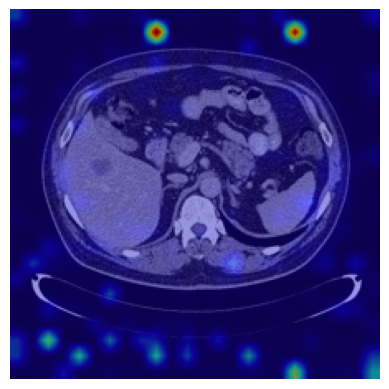

In [10]:
# IMAGE_TOKEN_INDEX
img_token_idx = int(torch.where(input_ids == -200)[1])
img_token_idx
for i in range(3, 5):
    attn_all_layers = cache['MistralAttention.forward'][32*(i+1):32*(i+2)]
    token = tokenizer.decode(outputs["sequences"][0][i])
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+H*W].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)
    # fig.savefig(f'vis_med/tokens/img_{i}_{token}.png',dpi=300,bbox_inches='tight')

### Masking and training

In [11]:
iw, ih = image.size
image.size

(512, 512)

In [12]:
import torchvision.transforms as transforms
n_px = 224
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(n_px, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.CenterCrop(n_px),
    transforms.Resize(H, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
])


In [9]:
mask = torch.zeros(size=(ih, iw))
bbox = [60, 200, 250, 380]
x_min, y_min, x_max, y_max = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
mask[y_min: y_max, x_min: x_max] = 1
mask = transform(mask.numpy())[0]
mask = mask.cuda() if torch.cuda.is_available() else mask

In [18]:
# for i in range(4, 5):
#     attn_all_layers = cache['MistralAttention.forward'][32*(i+1):32*(i+2)]
#     token = tokenizer.decode(outputs["sequences"][0][i])
#     attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
#     fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+H*W].mean(axis=0).mean(axis=0), image, orig_image=image, mask=mask, preprocess=preprocess, only_map=True, show_mask=True)


In [17]:
### 
# def get_attention_weights_example(question, image_path, conv_mode="plain"):
def simple_generation(question, image_path):
    conv_mode="plain"
    qs = question.replace(DEFAULT_IMAGE_TOKEN, '').strip()
    # cur_prompt = qs
    # qs = question
    if model.config.mm_use_im_start_end:
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    image = Image.open(image_path)

    image_tensor, images = process_images([image], image_processor, model.config)
    image = images[0]
    image_size = image.size
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2

    inputs, position_ids,attention_mask, _, inputs_embeds, _= model.prepare_inputs_labels_for_multimodal(
        input_ids,
        None,None,None,None,
        images=image_tensor.unsqueeze(0).half().cuda(),
        image_sizes=[image_size]
    )
    with torch.no_grad():
        outputs = model.generate(
            inputs_embeds=inputs_embeds,
            do_sample=False,
            max_new_tokens=64,
            use_cache=True,
            return_dict_in_generate=True,
            output_attentions=False,
            output_scores=False
        )
    text = tokenizer.decode(outputs["sequences"][0]).strip()
    print(text)

    return text


In [18]:
conv_mode="plain"
qs = question.replace(DEFAULT_IMAGE_TOKEN, '').strip()
# cur_prompt = qs
# qs = question
if model.config.mm_use_im_start_end:
    qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
else:
    qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

conv = conv_templates[conv_mode].copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

image = Image.open(image_path)

image_tensor, images = process_images([image], image_processor, model.config)
image = images[0]
image_size = image.size
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2

inputs, position_ids,attention_mask, _, inputs_embeds, _= model.prepare_inputs_labels_for_multimodal(
    input_ids,
    None,None,None,None,
    images=image_tensor.unsqueeze(0).half().cuda(),
    image_sizes=[image_size]
)



In [19]:
with torch.no_grad():
    outputs = model.generate(
        inputs_embeds=inputs_embeds,
        do_sample=False,
        max_new_tokens=64,
        use_cache=True,
        
        return_dict_in_generate=True,
        output_attentions=False,
        output_scores=False
    )
text = tokenizer.decode(outputs["sequences"][0]).strip()
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>


In [14]:

# simple_generation(question, image_path)

In [20]:
question2_list = ["Is there any abnormality on the liver ?", "what is this organ in the image?"]
for q in question2_list:
    simple_generation(q, image_path)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>
 According to the image, the liver appears to be normal. </s>
<s>The organ in the image is the spleen, which is part of the lymphatic system and is located in the upper left part of the abdomen. </s>


### Traning example

In [12]:
get_local.clear()
torch.cuda.empty_cache()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


0 <s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


1 <s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


2 <s> Question Question Question Question Q Question Q Question Q Question Q Question Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q
Loss change percentage exceeds threshold. Stop.


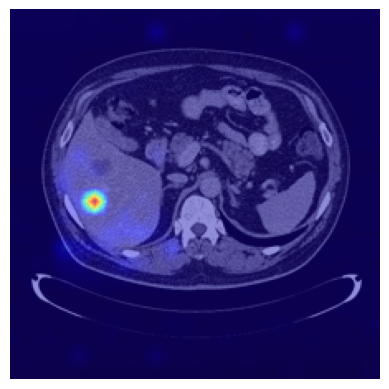

In [16]:
# init learnable Latent Variable
img_token_idx = int(torch.where(input_ids == -200)[1])
visual_prompt = torch.nn.Parameter(torch.zeros_like(inputs_embeds[:,img_token_idx:img_token_idx+H*W,:]))
loss_history = []
vprompt_history = visual_prompt

# start optimization x T
loss_history = []
T = 4
mask_choice = "box"
show_att, early_stop = True, True
beta, alpha, lr, loss_change_percent_threshold = 0.5, 400, 1, 25
for _ in range(T):
    new_inputs_embeds = inputs_embeds
    vprompt_cur = beta * visual_prompt + (1-beta) * vprompt_history  # EMA
    new_inputs_embeds[:,img_token_idx:img_token_idx+H*W,:] += vprompt_cur
    outputs = model.generate(inputs_embeds=new_inputs_embeds, attention_mask=attention_mask, output_attentions=True,
                             max_new_tokens=30, return_dict_in_generate=True, output_scores=True)
    cache = get_local.cache

    generate_ids = outputs.sequences
    logits = outputs.scores

    result_ids = generate_ids
    output = tokenizer.decode(outputs["sequences"][0]).strip()
    # output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    print(_, output)

    # ori_attention_maps = cache['MistralAttention.forward']
    ori_attention_maps = [i for i in cache['MistralAttention.forward'] if i is not None]
    attention_maps = [att.to(device) for i,att in enumerate(ori_attention_maps) if att.shape[-2] > 1]
    # attention_maps = [att.to(device) for i,att in enumerate(ori_attention_maps)]

    mean_att = torch.cat(attention_maps, 0).mean(0)

    fig = None
    if show_att:
        fig = show_image_relevance( mean_att[:, img_token_idx+H*W:,img_token_idx:img_token_idx+H*W].mean(axis=0).mean(axis=0), image, orig_image=image, mask=mask, preprocess=preprocess, only_map=True, show_mask=True)

        fig.savefig('vis_med/train_example/train_process/img_train_{}.png'.format(_),dpi=300,bbox_inches='tight')


    target2img_rel = mean_att[:, img_token_idx+H*W:,img_token_idx:img_token_idx+H*W].mean(axis=0).mean(axis=0).unsqueeze(0)
    
    loss = alpha * compute_ca_loss(target2img_rel.to(mask.device), masks=[mask], choice=mask_choice, object_positions=None)
    # print(loss)
    loss_history.append(loss.item())

    vprompt_history = vprompt_cur

    if early_stop:
        if len(loss_history) > 2:
            loss_change_percent = np.abs((loss_history[-1] - loss_history[0]) / loss_history[0]) * 100
            
            if loss_change_percent > loss_change_percent_threshold:
                print("Loss change percentage exceeds threshold. Stop.")

                break
        
        if len(loss_history) > 1:
            if loss_history[-1] > loss_history[-2]:
                break

    # vprompt_history = vprompt_cur
    grad_cond = torch.autograd.grad(loss.requires_grad_(True), [visual_prompt], retain_graph=True)[0]
    
    visual_prompt = visual_prompt - lr * grad_cond


    get_local.clear()
    torch.cuda.empty_cache()

### Function for inference tuning

In [9]:
def simple_tuning(question, image_path, mask, question_id=1, beta=0.5, alpha=400, lr=1, loss_change_percent_threshold=25):

    # the original generation result
    ori_text = simple_generation(question, image_path)
    print(f"the original output: {ori_text}")

    conv_mode="plain"
    qs = question.replace(DEFAULT_IMAGE_TOKEN, '').strip()
    # cur_prompt = qs
    
    # qs = question
    if model.config.mm_use_im_start_end:
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    img_token_idx = int(torch.where(input_ids == -200)[1])

    image = Image.open(image_path)

    image_tensor, images = process_images([image], image_processor, model.config)
    image = images[0]
    image_size = image.size
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2

    inputs, position_ids,attention_mask, _, inputs_embeds, _= model.prepare_inputs_labels_for_multimodal(
        input_ids,
        None,None,None,None,
        images=image_tensor.unsqueeze(0).half().cuda(),
        image_sizes=[image_size]
    )

    
    # init learnable Latent Variable
    visual_prompt = torch.nn.Parameter(torch.zeros_like(inputs_embeds[:,img_token_idx:img_token_idx+H*W,:]))
    loss_history = []
    vprompt_history = visual_prompt

    # start optimization x T
    loss_history = []
    T = 5
    mask_choice = "box"
    show_att, early_stop = True, True
    beta, alpha, lr, loss_change_percent_threshold = beta, alpha, lr, loss_change_percent_threshold
    get_local.clear()
    torch.cuda.empty_cache()
    for _ in range(T):
        new_inputs_embeds = inputs_embeds
        vprompt_cur = beta * visual_prompt + (1-beta) * vprompt_history  # EMA
        new_inputs_embeds[:,img_token_idx:img_token_idx+H*W,:] += vprompt_cur
        outputs = model.generate(inputs_embeds=new_inputs_embeds, attention_mask=attention_mask, output_attentions=True,
                                max_new_tokens=30, return_dict_in_generate=True, output_scores=True)
        cache = get_local.cache

        generate_ids = outputs.sequences
        logits = outputs.scores

        result_ids = generate_ids
        output = tokenizer.decode(outputs["sequences"][0]).strip()
        # output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        print("Step:", _, output)

        # ori_attention_maps = cache['MistralAttention.forward']
        # print(cache.keys())
        # print([len(cache[i]) for i in list(cache.keys())])
        # print(cache)
        # ori_attention_maps = [i for i in cache['MistralAttention.forward'] if i is not None][32:]
        # print(len(ori_attention_maps), "cwoe", ori_attention_maps[0].size())
        # # attention_maps = [att.to(device) for i, att in enumerate(ori_attention_maps) if att.shape[-2] > 1]
        # attention_maps = [att.to(device) for i, att in enumerate(ori_attention_maps[32:64])]

        ori_attention_maps = [i for i in cache['MistralAttention.forward'] if i is not None]
        attention_maps = [att.to(device) for i,att in enumerate(ori_attention_maps) if att.shape[-2] > 1]

        mean_att = torch.cat(attention_maps, 0).mean(0)

        fig = None
        if show_att:
            fig = show_image_relevance( mean_att[:, img_token_idx+H*W:,img_token_idx:img_token_idx+H*W].mean(axis=0).mean(axis=0), image, orig_image=image, mask=mask, preprocess=preprocess, only_map=True, show_mask=True)

            fig.savefig(f'vis_med/train_example/train_process{question_id}/img_train_{_}.png',dpi=300,bbox_inches='tight')


        target2img_rel = mean_att[:, img_token_idx+H*W:,img_token_idx:img_token_idx+H*W].mean(axis=0).mean(axis=0).unsqueeze(0)
        
        loss = alpha * compute_ca_loss(target2img_rel.to(mask.device), masks=[mask], choice=mask_choice, object_positions=None)
        # print(loss)
        loss_history.append(loss.item())

        vprompt_history = vprompt_cur

        if early_stop:
            if len(loss_history) > 2:
                loss_change_percent = np.abs((loss_history[-1] - loss_history[0]) / loss_history[0]) * 100
                
                if loss_change_percent > loss_change_percent_threshold:
                    print("Loss change percentage exceeds threshold. Stop.")

                    break
            
            if len(loss_history) > 1:
                if loss_history[-1] > loss_history[-2]:
                    break

        # vprompt_history = vprompt_cur
        grad_cond = torch.autograd.grad(loss.requires_grad_(True), [visual_prompt], retain_graph=True)[0]
        
        visual_prompt = visual_prompt - lr * grad_cond


        get_local.clear()
        torch.cuda.empty_cache()


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>The organ in the image is the spleen, which is part of the lymphatic system and is located in the upper left part of the abdomen. </s>
the original output: <s>The organ in the image is the spleen, which is part of the lymphatic system and is located in the upper left part of the abdomen. </s>
Step: 0 <s>The organ in the image is the spleen, which is part of the lymphatic system and is located in the upper left part of the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 1 <s>The organ in the image is the liver, which is a large, vital organ in the human body. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 2 <s> Question Q Q    Q Q # Q Question Q Question Q Q #  #     Q # Q #  Q # Question
Loss change percentage exceeds threshold. Stop.


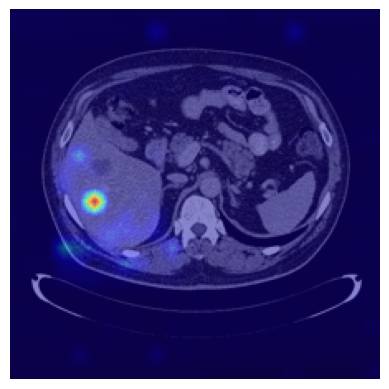

In [21]:
question2_list = ["Is there any abnormality on the liver ?", "what is this organ in the image?"]
image_path = "./images/med/example1.jpg"
simple_tuning(question=question2_list[1], image_path=image_path, question_id=2)

In [16]:
get_local.clear()
torch.cuda.empty_cache()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>The organ in the image is the spleen, which is part of the lymphatic system and is located in the upper left part of the abdomen. </s>
the original output: <s>The organ in the image is the spleen, which is part of the lymphatic system and is located in the upper left part of the abdomen. </s>
Step: 0 <s>The organ in the image is the spleen, which is part of the lymphatic system and is located in the upper left part of the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 1 <s>The organ in the image is the liver, which is a large, vital organ in the human body. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 2 <s>
 The organ in the image is the liver, which is a large, vital organ in the human body. </s>
Loss change percentage exceeds threshold. Stop.


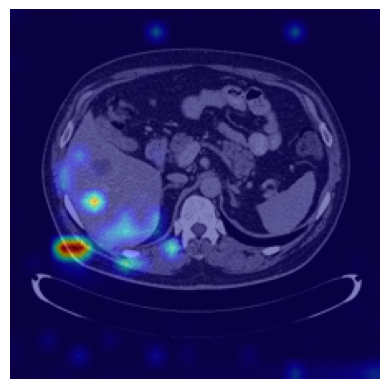

In [17]:
#### Slower loss backward v1

question2_list = ["Is there any abnormality on the liver ?", "what is this organ in the image?"]
image_path = "./images/med/example1.jpg"
simple_tuning(question=question2_list[1], image_path=image_path, question_id=2, beta=0.5, alpha=200, lr=1, loss_change_percent_threshold=25)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>The organ in the image is the spleen, which is part of the lymphatic system and is located in the upper left part of the abdomen. </s>
the original output: <s>The organ in the image is the spleen, which is part of the lymphatic system and is located in the upper left part of the abdomen. </s>
Step: 0 <s>The organ in the image is the spleen, which is part of the lymphatic system and is located in the upper left part of the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 1 <s>The organ in the image is the liver, which is a vital organ in the human body. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 2 <s>The organ in the image is the liver, which is a vital organ in the human body. </s>
Loss change percentage exceeds threshold. Stop.


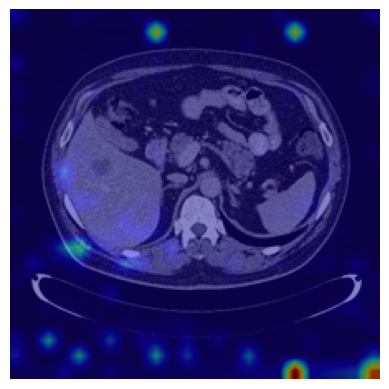

In [18]:
#### Slower loss backward v2

question2_list = ["Is there any abnormality on the liver ?", "what is this organ in the image?"]
image_path = "./images/med/example1.jpg"
simple_tuning(question=question2_list[1], image_path=image_path, question_id=2, beta=0.5, alpha=200, lr=0.5, loss_change_percent_threshold=25)

#### Slower loss backward


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


the original output: <s>
 According to the image, the liver appears to be normal. </s>
Step: 0 <s>
 According to the image, the liver appears to be normal. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 1 <s>
 According to the image, there is no abnormality on the liver. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 2 <s></s>
Loss change percentage exceeds threshold. Stop.


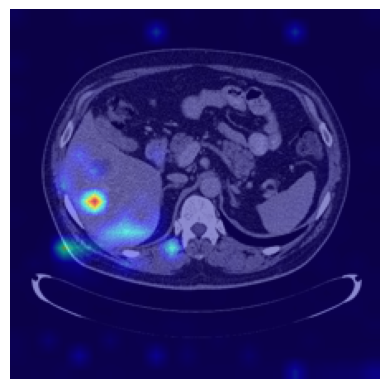

In [17]:
question2_list = ["Is there any abnormality on the liver ?", "what is this organ in the image?"]
simple_tuning(question=question2_list[0], image_path=image_path, question_id=1)

In [16]:
get_local.clear()
torch.cuda.empty_cache()

### Mask for cancer

In [15]:
mask_cancer = torch.zeros(size=(ih, iw))
bbox = [100, 190, 160, 250]
x_min, y_min, x_max, y_max = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
mask_cancer[y_min: y_max, x_min: x_max] = 1

mask_cancer = transform(mask_cancer.numpy())[0]
mask_cancer = mask_cancer.cuda() if torch.cuda.is_available() else mask_cancer

In [16]:
# question2_list = ["Is there any abnormality on the liver?", "what is this organ in the image?", "Does the image show any signs of liver cancer?", "Metastatic liver cancer often appears as multiple round lesions scattered throughout the liver. Does the image show any signs of liver cancer?"]
# image_path = "./images/med/example1.jpg"
# simple_tuning(question=question2_list[2], mask=mask_cancer, image_path=image_path, question_id=3, beta=0.5, alpha=200, lr=1, loss_change_percent_threshold=25)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>
the original output: <s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>
Step: 0 <s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 1 <s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 2 <s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 3 <s>
 The image does not show any signs of liver cancer. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 4 <s>
 The image is a computed tomography (ct) scan of the abdomen, and it does not show any signs of liver cancer.
Loss change percentage exceeds threshold. Stop.


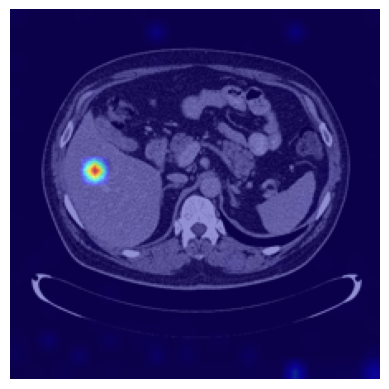

In [17]:
question2_list = ["Is there any abnormality on the liver?", "what is this organ in the image?", "Does the image show any signs of liver cancer?", "Metastatic liver cancer often appears as multiple round lesions scattered throughout the liver. Does the image show any signs of liver cancer?"]
image_path = "./images/med/example1.jpg"
simple_tuning(question=question2_list[2], mask=mask_cancer, image_path=image_path, question_id=3, beta=0.5, alpha=200, lr=0.25, loss_change_percent_threshold=25)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>
the original output: <s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>
Step: 0 <s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 1 <s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 2 <s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 3 <s>
 The image does not show any signs of liver cancer. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 4 <s> Question Question Question Question Question Question Question Question Question Question Question Question Question Question Question Question Question Question Question Question Question Question Question Q Question Q Question Q Question Q


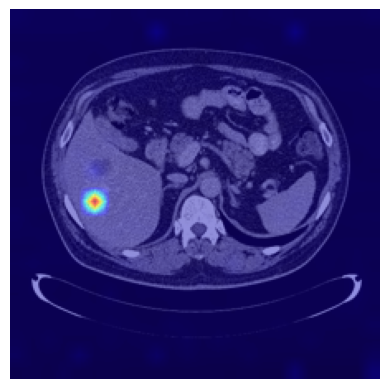

In [18]:
# mask v2
question2_list = ["Is there any abnormality on the liver?", "what is this organ in the image?", "Does the image show any signs of liver cancer?", "Metastatic liver cancer often appears as multiple round lesions scattered throughout the liver. Does the image show any signs of liver cancer?"]
image_path = "./images/med/example1.jpg"
simple_tuning(question=question2_list[2], mask=mask_cancer, image_path=image_path, question_id=3, beta=0.5, alpha=200, lr=0.25, loss_change_percent_threshold=25)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>
 According to the image, the liver appears to be normal. </s>
the original output: <s>
 According to the image, the liver appears to be normal. </s>
Step: 0 <s>
 According to the image, the liver appears to be normal. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 1 <s>
 According to the image, the liver appears to be normal. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 2 <s>
 According to the image, the liver appears to be normal. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 3 <s>
 Yes, there appears to be a liver abscess in the image. </s>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Step: 4 <s>
 Yes, there appears to be a liver abscess in the image. </s>
Loss change percentage exceeds threshold. Stop.


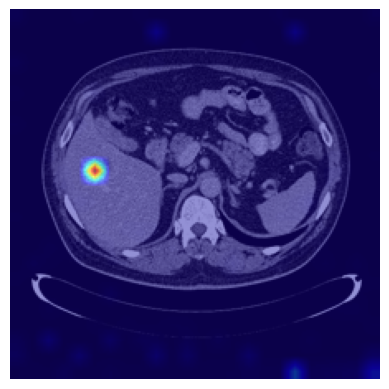

In [21]:
question2_list = ["Is there any abnormality on the liver?", "what is this organ in the image?", "Does the image show any signs of liver cancer?", "Metastatic liver cancer often appears as multiple round lesions scattered throughout the liver. Does the image show any signs of liver cancer?"]
image_path = "./images/med/example1.jpg"
simple_tuning(question=question2_list[0], mask=mask_cancer, image_path=image_path, question_id=1, beta=0.5, alpha=200, lr=0.25, loss_change_percent_threshold=25)

#### Knowledge

In [22]:
#normal image
question2_list = ["Is there any abnormality on the liver?", "what is this organ in the image?", "Does the image show any signs of liver cancer?", "Metastatic liver cancer often appears as multiple round lesions scattered throughout the liver. Does the image show any signs of liver cancer?"]
image_path = "./images/med/example_normal.jpg"
simple_generation(question=question2_list[3], image_path=image_path)
# simple_tuning(question=question2_list[3], mask=mask_cancer, image_path=image_path, question_id=4, beta=0.5, alpha=200, lr=0.5, loss_change_percent_threshold=25)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>
 The image shows multiple round lesions in the liver, which could be indicative of liver cancer. however, it is important to note that further diagnostic tests, such as a biopsy, would be necessary to confirm the presence of cancer and determine the specific type of liver cancer involved. </s>


'<s>\n The image shows multiple round lesions in the liver, which could be indicative of liver cancer. however, it is important to note that further diagnostic tests, such as a biopsy, would be necessary to confirm the presence of cancer and determine the specific type of liver cancer involved. </s>'

In [19]:
question2_list = ["Is there any abnormality on the liver?", "what is this organ in the image?", "Does the image show any signs of liver cancer?", "Metastatic liver cancer often appears as multiple round lesions scattered throughout the liver. Does the image show any signs of liver cancer?"]
image_path = "./images/med/example1.jpg"
simple_tuning(question=question2_list[3], mask=mask_cancer, image_path=image_path, question_id=4, beta=0.5, alpha=200, lr=0.5, loss_change_percent_threshold=25)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>
 The image shows multiple round lesions in the liver, which could be indicative of liver cancer. however, it is important to note that further diagnostic tests, such as a biopsy, would be necessary to confirm the presence of cancer and determine the specific type of liver cancer. </s>
the original output: <s>
 The image shows multiple round lesions in the liver, which could be indicative of liver cancer. however, it is important to note that further diagnostic tests, such as a biopsy, would be necessary to confirm the presence of cancer and determine the specific type of liver cancer. </s>
Step: 0 <s>
 The image shows multiple round lesions in the liver, which could be indicative of liver cancer. however, it is important to note that further


OutOfMemoryError: CUDA out of memory. Tried to allocate 720.00 MiB. GPU 